In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.4.0 True
2.4.0
10.1
GCC 7.3


In [2]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class LotteDataset(CustomDataset):

    CLASSES = ('ID_gum', 'buttering', 'couque_coffee', 'chocopie', 'cidar', 
               'couque_white', 'coke', 'diget_ori', 'diget_choco', 'gumi_gumi', 
               'homerunball', 'jjolbyung_noodle', 'juicyfresh', 'jjolbyung_ori', 
               'spearmint', 'squid_peanut', 'samdasu', 'tuna', 'toreta', 
               'vita500', 'welchs', 'zec')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('JPEGImages', 'Annotations')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[1:]] for x in content]

            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

In [3]:
from mmcv import Config
cfg = Config.fromfile('./mmdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

In [4]:
from mmdet.apis import set_random_seed

cfg.dataset_type = 'LotteDataset'
cfg.data_root = 'lotte_data/'

cfg.data.test.type = 'LotteDataset'
cfg.data.test.data_root = 'lotte_data/'
cfg.data.test.ann_file = 'train.txt'
cfg.data.test.img_prefix = 'training/JPEGImages'

cfg.data.train.type = 'LotteDataset'
cfg.data.train.data_root = 'lotte_data/'
cfg.data.train.ann_file = 'train.txt'
cfg.data.train.img_prefix = 'training/JPEGImages'

cfg.data.val.type = 'LotteDataset'
cfg.data.val.data_root = 'lotte_data/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/JPEGImages'

# num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 22
cfg.work_dir = './tutorial_exps'

# original learning rate는 GPU가 8개이므로, 자신의 GPU의 개수에 맞게 변형
cfg.optimizer.lr = 0.02 / 8 # 한 개만 쓸거니까
cfg.log_config.interval = 10

cfg.evaluation.metric = 'mAP'
# set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# ㄴet seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    pretrained='open-mmlab://detectron2/resnet50_caffe',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=False),
        norm_eval=True,
        style='caffe'),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0),
        los

In [5]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# dataset 구축
datasets = [build_dataset(cfg.data.train)]

# detector 구축
model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
model.CLASSES = datasets[0].CLASSES

mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2020-09-27 22:51:20,730 - mmdet - INFO - load model from: open-mmlab://detectron2/resnet50_caffe
2020-09-27 22:51:20,778 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: conv1.bias

2020-09-27 22:51:28,135 - mmdet - INFO - Start running, host: jmh@jmh-GE75-Raider-10SF, work_dir: /home/jmh/content/mmdetection_object_detection_demo/tutorial_exps
2020-09-27 22:51:28,135 - mmdet - INFO - workflow: [('train', 1)], max: 12 epochs
2020-09-27 22:51:33,862 - mmdet - INFO - Epoch [1][10/587]	lr: 4.746e-05, eta: 1:05:20, time: 0.557, data_time: 0.212, memory: 3492, loss_rpn_cls: 0.7243, loss_rpn_bbox: 0.1013, loss_cls: 2.2370, acc: 42.2559, loss_bbox: 0.0108, loss: 3.0734
2020-09-27 22:51:37,017 - mmdet - INFO - Epoch [1][20/587]	lr: 9.741e-05, eta: 0:51:08, time: 0.316, data_time: 0.018, memory: 3492, loss_rpn_cls: 0.6981, loss_rpn_bbox: 0.1079, loss_cls: 0.1861, acc: 97.8906, loss_bbox: 0.0197, loss: 1.0117
2020-09-27 22:51:40,388 - 

2020-09-27 22:53:30,486 - mmdet - INFO - Epoch [1][330/587]	lr: 1.646e-03, eta: 0:41:26, time: 0.383, data_time: 0.020, memory: 3611, loss_rpn_cls: 0.0379, loss_rpn_bbox: 0.0661, loss_cls: 0.4657, acc: 85.4785, loss_bbox: 0.6360, loss: 1.2058
2020-09-27 22:53:33,883 - mmdet - INFO - Epoch [1][340/587]	lr: 1.696e-03, eta: 0:41:16, time: 0.338, data_time: 0.018, memory: 3611, loss_rpn_cls: 0.0280, loss_rpn_bbox: 0.0627, loss_cls: 0.4608, acc: 85.8301, loss_bbox: 0.6659, loss: 1.2174
2020-09-27 22:53:37,404 - mmdet - INFO - Epoch [1][350/587]	lr: 1.746e-03, eta: 0:41:09, time: 0.353, data_time: 0.020, memory: 3611, loss_rpn_cls: 0.0228, loss_rpn_bbox: 0.0601, loss_cls: 0.4898, acc: 85.5762, loss_bbox: 0.6512, loss: 1.2240
2020-09-27 22:53:40,953 - mmdet - INFO - Epoch [1][360/587]	lr: 1.796e-03, eta: 0:41:02, time: 0.354, data_time: 0.019, memory: 3611, loss_rpn_cls: 0.0244, loss_rpn_bbox: 0.0565, loss_cls: 0.4427, acc: 86.3965, loss_bbox: 0.6471, loss: 1.1707
2020-09-27 22:53:44,685 - mm

2020-09-27 22:55:35,135 - mmdet - INFO - Epoch [2][90/587]	lr: 2.500e-03, eta: 0:38:17, time: 0.354, data_time: 0.023, memory: 3611, loss_rpn_cls: 0.0093, loss_rpn_bbox: 0.0465, loss_cls: 0.2652, acc: 91.0352, loss_bbox: 0.4210, loss: 0.7420
2020-09-27 22:55:38,708 - mmdet - INFO - Epoch [2][100/587]	lr: 2.500e-03, eta: 0:38:13, time: 0.358, data_time: 0.018, memory: 3611, loss_rpn_cls: 0.0123, loss_rpn_bbox: 0.0489, loss_cls: 0.2478, acc: 91.4844, loss_bbox: 0.4303, loss: 0.7393
2020-09-27 22:55:42,123 - mmdet - INFO - Epoch [2][110/587]	lr: 2.500e-03, eta: 0:38:08, time: 0.343, data_time: 0.017, memory: 3611, loss_rpn_cls: 0.0125, loss_rpn_bbox: 0.0459, loss_cls: 0.2470, acc: 91.8652, loss_bbox: 0.4211, loss: 0.7265
2020-09-27 22:55:45,724 - mmdet - INFO - Epoch [2][120/587]	lr: 2.500e-03, eta: 0:38:04, time: 0.357, data_time: 0.015, memory: 3611, loss_rpn_cls: 0.0150, loss_rpn_bbox: 0.0476, loss_cls: 0.2520, acc: 91.6211, loss_bbox: 0.4265, loss: 0.7411
2020-09-27 22:55:49,035 - mmd

2020-09-27 22:57:34,825 - mmdet - INFO - Epoch [2][430/587]	lr: 2.500e-03, eta: 0:35:56, time: 0.378, data_time: 0.022, memory: 3611, loss_rpn_cls: 0.0070, loss_rpn_bbox: 0.0385, loss_cls: 0.2146, acc: 92.8809, loss_bbox: 0.3539, loss: 0.6141
2020-09-27 22:57:38,222 - mmdet - INFO - Epoch [2][440/587]	lr: 2.500e-03, eta: 0:35:52, time: 0.343, data_time: 0.022, memory: 3611, loss_rpn_cls: 0.0078, loss_rpn_bbox: 0.0350, loss_cls: 0.1873, acc: 93.8965, loss_bbox: 0.3704, loss: 0.6004
2020-09-27 22:57:41,582 - mmdet - INFO - Epoch [2][450/587]	lr: 2.500e-03, eta: 0:35:47, time: 0.336, data_time: 0.019, memory: 3611, loss_rpn_cls: 0.0077, loss_rpn_bbox: 0.0329, loss_cls: 0.2072, acc: 92.9688, loss_bbox: 0.3599, loss: 0.6077
2020-09-27 22:57:45,203 - mmdet - INFO - Epoch [2][460/587]	lr: 2.500e-03, eta: 0:35:44, time: 0.362, data_time: 0.019, memory: 3611, loss_rpn_cls: 0.0086, loss_rpn_bbox: 0.0385, loss_cls: 0.2227, acc: 92.2852, loss_bbox: 0.3734, loss: 0.6431
2020-09-27 22:57:48,588 - mm

2020-09-27 22:59:38,941 - mmdet - INFO - Epoch [3][190/587]	lr: 2.500e-03, eta: 0:33:41, time: 0.333, data_time: 0.024, memory: 3611, loss_rpn_cls: 0.0054, loss_rpn_bbox: 0.0349, loss_cls: 0.1655, acc: 94.2871, loss_bbox: 0.3177, loss: 0.5234
2020-09-27 22:59:42,578 - mmdet - INFO - Epoch [3][200/587]	lr: 2.500e-03, eta: 0:33:38, time: 0.360, data_time: 0.017, memory: 3611, loss_rpn_cls: 0.0052, loss_rpn_bbox: 0.0360, loss_cls: 0.2246, acc: 92.9102, loss_bbox: 0.3343, loss: 0.6002
2020-09-27 22:59:46,168 - mmdet - INFO - Epoch [3][210/587]	lr: 2.500e-03, eta: 0:33:35, time: 0.362, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0059, loss_rpn_bbox: 0.0319, loss_cls: 0.1806, acc: 93.7695, loss_bbox: 0.3146, loss: 0.5330
2020-09-27 22:59:49,718 - mmdet - INFO - Epoch [3][220/587]	lr: 2.500e-03, eta: 0:33:31, time: 0.354, data_time: 0.017, memory: 3611, loss_rpn_cls: 0.0062, loss_rpn_bbox: 0.0363, loss_cls: 0.1896, acc: 93.6621, loss_bbox: 0.3405, loss: 0.5726
2020-09-27 22:59:53,551 - mm

2020-09-27 23:01:39,812 - mmdet - INFO - Epoch [3][530/587]	lr: 2.500e-03, eta: 0:31:40, time: 0.350, data_time: 0.023, memory: 3611, loss_rpn_cls: 0.0055, loss_rpn_bbox: 0.0348, loss_cls: 0.1720, acc: 94.1992, loss_bbox: 0.3098, loss: 0.5221
2020-09-27 23:01:43,373 - mmdet - INFO - Epoch [3][540/587]	lr: 2.500e-03, eta: 0:31:36, time: 0.355, data_time: 0.020, memory: 3611, loss_rpn_cls: 0.0095, loss_rpn_bbox: 0.0310, loss_cls: 0.1681, acc: 94.7559, loss_bbox: 0.3107, loss: 0.5194
2020-09-27 23:01:46,831 - mmdet - INFO - Epoch [3][550/587]	lr: 2.500e-03, eta: 0:31:32, time: 0.345, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0105, loss_rpn_bbox: 0.0301, loss_cls: 0.1707, acc: 94.0332, loss_bbox: 0.3233, loss: 0.5345
2020-09-27 23:01:50,407 - mmdet - INFO - Epoch [3][560/587]	lr: 2.500e-03, eta: 0:31:29, time: 0.358, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0048, loss_rpn_bbox: 0.0314, loss_cls: 0.1686, acc: 94.4043, loss_bbox: 0.3099, loss: 0.5148
2020-09-27 23:01:54,028 - mm

2020-09-27 23:03:44,466 - mmdet - INFO - Epoch [4][290/587]	lr: 2.500e-03, eta: 0:29:33, time: 0.366, data_time: 0.017, memory: 3611, loss_rpn_cls: 0.0055, loss_rpn_bbox: 0.0313, loss_cls: 0.1979, acc: 94.8438, loss_bbox: 0.3081, loss: 0.5428
2020-09-27 23:03:48,136 - mmdet - INFO - Epoch [4][300/587]	lr: 2.500e-03, eta: 0:29:29, time: 0.365, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0034, loss_rpn_bbox: 0.0288, loss_cls: 0.1533, acc: 95.2148, loss_bbox: 0.2905, loss: 0.4760
2020-09-27 23:03:51,604 - mmdet - INFO - Epoch [4][310/587]	lr: 2.500e-03, eta: 0:29:26, time: 0.350, data_time: 0.023, memory: 3611, loss_rpn_cls: 0.0042, loss_rpn_bbox: 0.0305, loss_cls: 0.1676, acc: 94.5801, loss_bbox: 0.2869, loss: 0.4892
2020-09-27 23:03:55,356 - mmdet - INFO - Epoch [4][320/587]	lr: 2.500e-03, eta: 0:29:23, time: 0.375, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0058, loss_rpn_bbox: 0.0337, loss_cls: 0.1640, acc: 94.6191, loss_bbox: 0.3084, loss: 0.5119
2020-09-27 23:03:59,000 - mm

2020-09-27 23:05:50,412 - mmdet - INFO - Epoch [5][50/587]	lr: 2.500e-03, eta: 0:27:29, time: 0.359, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0034, loss_rpn_bbox: 0.0287, loss_cls: 0.1376, acc: 94.8145, loss_bbox: 0.2842, loss: 0.4539
2020-09-27 23:05:53,892 - mmdet - INFO - Epoch [5][60/587]	lr: 2.500e-03, eta: 0:27:26, time: 0.346, data_time: 0.022, memory: 3611, loss_rpn_cls: 0.0041, loss_rpn_bbox: 0.0310, loss_cls: 0.1428, acc: 95.2539, loss_bbox: 0.2797, loss: 0.4575
2020-09-27 23:05:57,521 - mmdet - INFO - Epoch [5][70/587]	lr: 2.500e-03, eta: 0:27:22, time: 0.362, data_time: 0.023, memory: 3611, loss_rpn_cls: 0.0047, loss_rpn_bbox: 0.0272, loss_cls: 0.1501, acc: 95.1270, loss_bbox: 0.2732, loss: 0.4551
2020-09-27 23:06:00,943 - mmdet - INFO - Epoch [5][80/587]	lr: 2.500e-03, eta: 0:27:19, time: 0.346, data_time: 0.025, memory: 3611, loss_rpn_cls: 0.0045, loss_rpn_bbox: 0.0303, loss_cls: 0.1377, acc: 95.0781, loss_bbox: 0.2741, loss: 0.4465
2020-09-27 23:06:04,559 - mmdet 

2020-09-27 23:07:50,224 - mmdet - INFO - Epoch [5][390/587]	lr: 2.500e-03, eta: 0:25:27, time: 0.357, data_time: 0.020, memory: 3611, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0238, loss_cls: 0.1840, acc: 95.0586, loss_bbox: 0.2720, loss: 0.4835
2020-09-27 23:07:53,781 - mmdet - INFO - Epoch [5][400/587]	lr: 2.500e-03, eta: 0:25:24, time: 0.351, data_time: 0.019, memory: 3611, loss_rpn_cls: 0.0061, loss_rpn_bbox: 0.0305, loss_cls: 0.1775, acc: 94.8633, loss_bbox: 0.2734, loss: 0.4875
2020-09-27 23:07:57,459 - mmdet - INFO - Epoch [5][410/587]	lr: 2.500e-03, eta: 0:25:20, time: 0.368, data_time: 0.023, memory: 3611, loss_rpn_cls: 0.0036, loss_rpn_bbox: 0.0276, loss_cls: 0.1865, acc: 95.0293, loss_bbox: 0.2573, loss: 0.4750
2020-09-27 23:08:00,952 - mmdet - INFO - Epoch [5][420/587]	lr: 2.500e-03, eta: 0:25:17, time: 0.354, data_time: 0.023, memory: 3611, loss_rpn_cls: 0.0039, loss_rpn_bbox: 0.0271, loss_cls: 0.1595, acc: 95.0586, loss_bbox: 0.2646, loss: 0.4551
2020-09-27 23:08:04,435 - mm

2020-09-27 23:09:55,484 - mmdet - INFO - Epoch [6][150/587]	lr: 2.500e-03, eta: 0:23:24, time: 0.364, data_time: 0.019, memory: 3611, loss_rpn_cls: 0.0039, loss_rpn_bbox: 0.0262, loss_cls: 0.1549, acc: 96.2891, loss_bbox: 0.2414, loss: 0.4264
2020-09-27 23:09:59,089 - mmdet - INFO - Epoch [6][160/587]	lr: 2.500e-03, eta: 0:23:20, time: 0.361, data_time: 0.019, memory: 3611, loss_rpn_cls: 0.0030, loss_rpn_bbox: 0.0257, loss_cls: 0.1777, acc: 95.9961, loss_bbox: 0.2549, loss: 0.4613
2020-09-27 23:10:02,285 - mmdet - INFO - Epoch [6][170/587]	lr: 2.500e-03, eta: 0:23:16, time: 0.318, data_time: 0.018, memory: 3611, loss_rpn_cls: 0.0049, loss_rpn_bbox: 0.0245, loss_cls: 0.1410, acc: 95.6348, loss_bbox: 0.2770, loss: 0.4474
2020-09-27 23:10:05,904 - mmdet - INFO - Epoch [6][180/587]	lr: 2.500e-03, eta: 0:23:13, time: 0.361, data_time: 0.020, memory: 3611, loss_rpn_cls: 0.0033, loss_rpn_bbox: 0.0226, loss_cls: 0.2205, acc: 95.2930, loss_bbox: 0.2528, loss: 0.4991
2020-09-27 23:10:09,245 - mm

2020-09-27 23:11:56,120 - mmdet - INFO - Epoch [6][490/587]	lr: 2.500e-03, eta: 0:21:23, time: 0.383, data_time: 0.024, memory: 3611, loss_rpn_cls: 0.0035, loss_rpn_bbox: 0.0257, loss_cls: 0.1744, acc: 95.7617, loss_bbox: 0.2575, loss: 0.4610
2020-09-27 23:11:59,728 - mmdet - INFO - Epoch [6][500/587]	lr: 2.500e-03, eta: 0:21:20, time: 0.356, data_time: 0.016, memory: 3611, loss_rpn_cls: 0.0038, loss_rpn_bbox: 0.0312, loss_cls: 0.1670, acc: 95.3125, loss_bbox: 0.2600, loss: 0.4620
2020-09-27 23:12:03,553 - mmdet - INFO - Epoch [6][510/587]	lr: 2.500e-03, eta: 0:21:16, time: 0.383, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0240, loss_cls: 0.1547, acc: 95.6934, loss_bbox: 0.2450, loss: 0.4263
2020-09-27 23:12:07,159 - mmdet - INFO - Epoch [6][520/587]	lr: 2.500e-03, eta: 0:21:13, time: 0.363, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0051, loss_rpn_bbox: 0.0258, loss_cls: 0.1342, acc: 95.8496, loss_bbox: 0.2618, loss: 0.4269
2020-09-27 23:12:10,576 - mm

2020-09-27 23:14:01,064 - mmdet - INFO - Epoch [7][250/587]	lr: 2.500e-03, eta: 0:19:19, time: 0.350, data_time: 0.017, memory: 3611, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0235, loss_cls: 0.1319, acc: 95.4395, loss_bbox: 0.2599, loss: 0.4178
2020-09-27 23:14:04,622 - mmdet - INFO - Epoch [7][260/587]	lr: 2.500e-03, eta: 0:19:16, time: 0.355, data_time: 0.018, memory: 3611, loss_rpn_cls: 0.0042, loss_rpn_bbox: 0.0239, loss_cls: 0.1233, acc: 95.4688, loss_bbox: 0.2572, loss: 0.4086
2020-09-27 23:14:08,056 - mmdet - INFO - Epoch [7][270/587]	lr: 2.500e-03, eta: 0:19:12, time: 0.341, data_time: 0.019, memory: 3611, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0234, loss_cls: 0.1011, acc: 96.2598, loss_bbox: 0.2224, loss: 0.3489
2020-09-27 23:14:11,637 - mmdet - INFO - Epoch [7][280/587]	lr: 2.500e-03, eta: 0:19:09, time: 0.362, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0207, loss_cls: 0.1160, acc: 95.9863, loss_bbox: 0.2365, loss: 0.3751
2020-09-27 23:14:15,313 - mm

2020-09-27 23:16:06,729 - mmdet - INFO - Epoch [8][10/587]	lr: 2.500e-03, eta: 0:17:16, time: 0.553, data_time: 0.211, memory: 3611, loss_rpn_cls: 0.0032, loss_rpn_bbox: 0.0238, loss_cls: 0.1207, acc: 96.1914, loss_bbox: 0.2357, loss: 0.3834
2020-09-27 23:16:10,084 - mmdet - INFO - Epoch [8][20/587]	lr: 2.500e-03, eta: 0:17:13, time: 0.336, data_time: 0.019, memory: 3611, loss_rpn_cls: 0.0034, loss_rpn_bbox: 0.0281, loss_cls: 0.1116, acc: 96.2012, loss_bbox: 0.2341, loss: 0.3772
2020-09-27 23:16:13,508 - mmdet - INFO - Epoch [8][30/587]	lr: 2.500e-03, eta: 0:17:09, time: 0.338, data_time: 0.018, memory: 3611, loss_rpn_cls: 0.0034, loss_rpn_bbox: 0.0274, loss_cls: 0.1243, acc: 95.9277, loss_bbox: 0.2363, loss: 0.3913
2020-09-27 23:16:17,121 - mmdet - INFO - Epoch [8][40/587]	lr: 2.500e-03, eta: 0:17:06, time: 0.363, data_time: 0.022, memory: 3611, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0241, loss_cls: 0.1026, acc: 96.4062, loss_bbox: 0.2299, loss: 0.3594
2020-09-27 23:16:20,798 - mmdet 

2020-09-27 23:18:07,062 - mmdet - INFO - Epoch [8][350/587]	lr: 2.500e-03, eta: 0:15:16, time: 0.360, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0032, loss_rpn_bbox: 0.0225, loss_cls: 0.1067, acc: 96.3086, loss_bbox: 0.2270, loss: 0.3594
2020-09-27 23:18:10,768 - mmdet - INFO - Epoch [8][360/587]	lr: 2.500e-03, eta: 0:15:12, time: 0.367, data_time: 0.017, memory: 3611, loss_rpn_cls: 0.0037, loss_rpn_bbox: 0.0231, loss_cls: 0.1043, acc: 95.9473, loss_bbox: 0.2258, loss: 0.3569
2020-09-27 23:18:14,345 - mmdet - INFO - Epoch [8][370/587]	lr: 2.500e-03, eta: 0:15:09, time: 0.358, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0267, loss_cls: 0.1015, acc: 96.1035, loss_bbox: 0.2440, loss: 0.3744
2020-09-27 23:18:17,976 - mmdet - INFO - Epoch [8][380/587]	lr: 2.500e-03, eta: 0:15:05, time: 0.362, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0031, loss_rpn_bbox: 0.0250, loss_cls: 0.1001, acc: 96.3184, loss_bbox: 0.2258, loss: 0.3540
2020-09-27 23:18:21,633 - mm

2020-09-27 23:20:11,948 - mmdet - INFO - Epoch [9][110/587]	lr: 2.500e-04, eta: 0:13:12, time: 0.347, data_time: 0.022, memory: 3611, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0217, loss_cls: 0.1096, acc: 96.2695, loss_bbox: 0.1956, loss: 0.3286
2020-09-27 23:20:15,463 - mmdet - INFO - Epoch [9][120/587]	lr: 2.500e-04, eta: 0:13:09, time: 0.349, data_time: 0.016, memory: 3611, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0190, loss_cls: 0.0981, acc: 96.5137, loss_bbox: 0.1817, loss: 0.3009
2020-09-27 23:20:18,870 - mmdet - INFO - Epoch [9][130/587]	lr: 2.500e-04, eta: 0:13:05, time: 0.342, data_time: 0.019, memory: 3611, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0200, loss_cls: 0.0848, acc: 96.8848, loss_bbox: 0.1838, loss: 0.2907
2020-09-27 23:20:22,361 - mmdet - INFO - Epoch [9][140/587]	lr: 2.500e-04, eta: 0:13:02, time: 0.347, data_time: 0.017, memory: 3611, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0191, loss_cls: 0.0893, acc: 96.8457, loss_bbox: 0.1948, loss: 0.3050
2020-09-27 23:20:25,973 - mm

2020-09-27 23:22:12,455 - mmdet - INFO - Epoch [9][450/587]	lr: 2.500e-04, eta: 0:11:12, time: 0.334, data_time: 0.019, memory: 3611, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0167, loss_cls: 0.0685, acc: 97.4805, loss_bbox: 0.1757, loss: 0.2620
2020-09-27 23:22:15,960 - mmdet - INFO - Epoch [9][460/587]	lr: 2.500e-04, eta: 0:11:08, time: 0.349, data_time: 0.022, memory: 3611, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0180, loss_cls: 0.0836, acc: 96.8750, loss_bbox: 0.1860, loss: 0.2899
2020-09-27 23:22:19,407 - mmdet - INFO - Epoch [9][470/587]	lr: 2.500e-04, eta: 0:11:05, time: 0.350, data_time: 0.023, memory: 3611, loss_rpn_cls: 0.0015, loss_rpn_bbox: 0.0182, loss_cls: 0.0919, acc: 96.8652, loss_bbox: 0.1857, loss: 0.2973
2020-09-27 23:22:23,092 - mmdet - INFO - Epoch [9][480/587]	lr: 2.500e-04, eta: 0:11:01, time: 0.365, data_time: 0.017, memory: 3611, loss_rpn_cls: 0.0028, loss_rpn_bbox: 0.0177, loss_cls: 0.0825, acc: 96.6699, loss_bbox: 0.1941, loss: 0.2970
2020-09-27 23:22:26,609 - mm

2020-09-27 23:24:17,400 - mmdet - INFO - Epoch [10][210/587]	lr: 2.500e-04, eta: 0:09:09, time: 0.361, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0185, loss_cls: 0.0947, acc: 96.3184, loss_bbox: 0.1895, loss: 0.3044
2020-09-27 23:24:20,917 - mmdet - INFO - Epoch [10][220/587]	lr: 2.500e-04, eta: 0:09:05, time: 0.351, data_time: 0.017, memory: 3611, loss_rpn_cls: 0.0012, loss_rpn_bbox: 0.0179, loss_cls: 0.0950, acc: 96.6895, loss_bbox: 0.1837, loss: 0.2979
2020-09-27 23:24:24,620 - mmdet - INFO - Epoch [10][230/587]	lr: 2.500e-04, eta: 0:09:02, time: 0.367, data_time: 0.018, memory: 3611, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0173, loss_cls: 0.0868, acc: 96.7188, loss_bbox: 0.1896, loss: 0.2953
2020-09-27 23:24:28,203 - mmdet - INFO - Epoch [10][240/587]	lr: 2.500e-04, eta: 0:08:58, time: 0.362, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0192, loss_cls: 0.0753, acc: 97.0996, loss_bbox: 0.1781, loss: 0.2745
2020-09-27 23:24:31,677 

2020-09-27 23:26:18,468 - mmdet - INFO - Epoch [10][550/587]	lr: 2.500e-04, eta: 0:07:09, time: 0.340, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0018, loss_rpn_bbox: 0.0155, loss_cls: 0.0828, acc: 96.7480, loss_bbox: 0.1749, loss: 0.2750
2020-09-27 23:26:21,956 - mmdet - INFO - Epoch [10][560/587]	lr: 2.500e-04, eta: 0:07:05, time: 0.349, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0023, loss_rpn_bbox: 0.0162, loss_cls: 0.0808, acc: 96.8848, loss_bbox: 0.1744, loss: 0.2738
2020-09-27 23:26:25,360 - mmdet - INFO - Epoch [10][570/587]	lr: 2.500e-04, eta: 0:07:01, time: 0.344, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0043, loss_rpn_bbox: 0.0166, loss_cls: 0.0693, acc: 97.4219, loss_bbox: 0.1754, loss: 0.2656
2020-09-27 23:26:29,109 - mmdet - INFO - Epoch [10][580/587]	lr: 2.500e-04, eta: 0:06:58, time: 0.371, data_time: 0.017, memory: 3611, loss_rpn_cls: 0.0021, loss_rpn_bbox: 0.0153, loss_cls: 0.0780, acc: 97.2852, loss_bbox: 0.1767, loss: 0.2720
2020-09-27 23:26:36,994 

2020-09-27 23:28:22,912 - mmdet - INFO - Epoch [11][310/587]	lr: 2.500e-04, eta: 0:05:06, time: 0.347, data_time: 0.019, memory: 3611, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0180, loss_cls: 0.0881, acc: 96.4941, loss_bbox: 0.1864, loss: 0.2937
2020-09-27 23:28:26,543 - mmdet - INFO - Epoch [11][320/587]	lr: 2.500e-04, eta: 0:05:02, time: 0.363, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0203, loss_cls: 0.0906, acc: 97.0312, loss_bbox: 0.1792, loss: 0.2920
2020-09-27 23:28:30,250 - mmdet - INFO - Epoch [11][330/587]	lr: 2.500e-04, eta: 0:04:58, time: 0.370, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0173, loss_cls: 0.0815, acc: 96.9922, loss_bbox: 0.1834, loss: 0.2844
2020-09-27 23:28:33,758 - mmdet - INFO - Epoch [11][340/587]	lr: 2.500e-04, eta: 0:04:55, time: 0.352, data_time: 0.022, memory: 3611, loss_rpn_cls: 0.0025, loss_rpn_bbox: 0.0173, loss_cls: 0.0768, acc: 97.0020, loss_bbox: 0.1766, loss: 0.2732
2020-09-27 23:28:37,332 

2020-09-27 23:30:28,042 - mmdet - INFO - Epoch [12][70/587]	lr: 2.500e-05, eta: 0:03:03, time: 0.372, data_time: 0.022, memory: 3611, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0161, loss_cls: 0.0816, acc: 97.0312, loss_bbox: 0.1799, loss: 0.2793
2020-09-27 23:30:31,459 - mmdet - INFO - Epoch [12][80/587]	lr: 2.500e-05, eta: 0:02:59, time: 0.342, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0177, loss_cls: 0.0749, acc: 97.2656, loss_bbox: 0.1799, loss: 0.2738
2020-09-27 23:30:34,907 - mmdet - INFO - Epoch [12][90/587]	lr: 2.500e-05, eta: 0:02:55, time: 0.344, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0014, loss_rpn_bbox: 0.0172, loss_cls: 0.0857, acc: 96.4941, loss_bbox: 0.1868, loss: 0.2910
2020-09-27 23:30:38,442 - mmdet - INFO - Epoch [12][100/587]	lr: 2.500e-05, eta: 0:02:52, time: 0.357, data_time: 0.022, memory: 3611, loss_rpn_cls: 0.0016, loss_rpn_bbox: 0.0185, loss_cls: 0.0895, acc: 96.7871, loss_bbox: 0.1861, loss: 0.2957
2020-09-27 23:30:41,807 - m

2020-09-27 23:32:27,973 - mmdet - INFO - Epoch [12][410/587]	lr: 2.500e-05, eta: 0:01:02, time: 0.365, data_time: 0.021, memory: 3611, loss_rpn_cls: 0.0019, loss_rpn_bbox: 0.0156, loss_cls: 0.0758, acc: 97.0605, loss_bbox: 0.1676, loss: 0.2609
2020-09-27 23:32:31,611 - mmdet - INFO - Epoch [12][420/587]	lr: 2.500e-05, eta: 0:00:59, time: 0.364, data_time: 0.019, memory: 3611, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0169, loss_cls: 0.0851, acc: 96.6016, loss_bbox: 0.1739, loss: 0.2780
2020-09-27 23:32:35,430 - mmdet - INFO - Epoch [12][430/587]	lr: 2.500e-05, eta: 0:00:55, time: 0.383, data_time: 0.019, memory: 3611, loss_rpn_cls: 0.0017, loss_rpn_bbox: 0.0174, loss_cls: 0.0749, acc: 97.2363, loss_bbox: 0.1753, loss: 0.2693
2020-09-27 23:32:39,217 - mmdet - INFO - Epoch [12][440/587]	lr: 2.500e-05, eta: 0:00:52, time: 0.376, data_time: 0.018, memory: 3611, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0151, loss_cls: 0.0817, acc: 96.8945, loss_bbox: 0.1737, loss: 0.2719
2020-09-27 23:32:42,896 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 829/829, 11.7 task/s, elapsed: 71s, ETA:     0s

2020-09-27 23:34:48,353 - mmdet - INFO - 
+------------------+-----+------+--------+-------+
| class            | gts | dets | recall | ap    |
+------------------+-----+------+--------+-------+
| ID_gum           | 300 | 333  | 0.993  | 0.993 |
| buttering        | 232 | 323  | 0.974  | 0.970 |
| couque_coffee    | 394 | 536  | 0.972  | 0.942 |
| chocopie         | 307 | 408  | 0.997  | 0.989 |
| cidar            | 346 | 399  | 0.994  | 0.993 |
| couque_white     | 346 | 507  | 0.942  | 0.921 |
| coke             | 364 | 400  | 0.989  | 0.989 |
| diget_ori        | 347 | 462  | 0.988  | 0.969 |
| diget_choco      | 431 | 503  | 0.991  | 0.982 |
| gumi_gumi        | 295 | 435  | 0.993  | 0.993 |
| homerunball      | 302 | 533  | 0.980  | 0.979 |
| jjolbyung_noodle | 339 | 498  | 0.997  | 0.994 |
| juicyfresh       | 372 | 491  | 0.992  | 0.976 |
| jjolbyung_ori    | 370 | 546  | 0.976  | 0.976 |
| spearmint        | 267 | 348  | 0.959  | 0.951 |
| squid_peanut     | 339 | 554  | 1.000 

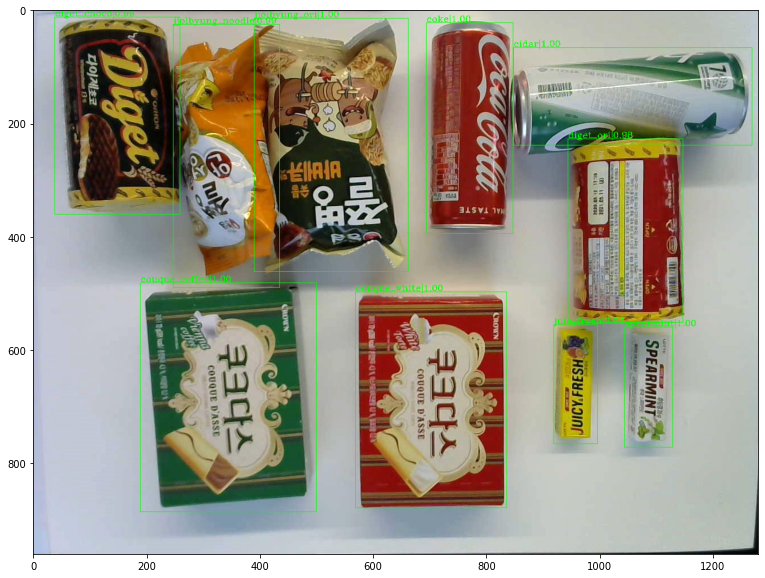

In [6]:
from mmdet.apis import inference_detector, show_result_pyplot
img = mmcv.imread('lotte_data/training/JPEGImages/0426.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)

In [7]:
torch.save(model.state_dict(), 'state_dicts/FasterRCNN_model_state_dict')